<a href="https://colab.research.google.com/github/seonleeuni/mge51101-20205196/blob/master/AlexNet_CIFAR_Seonmi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AlexNet Examples for CIFAR-10

- PyTorch Example code for AlexNet implementation

In [17]:
!nvidia-smi
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

Mon Apr 27 14:47:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |   3477MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Model & Hyperparameters


In [0]:
# Number of classes
num_classes = 10

# Loss function & Optimizers
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR

# Hyperparameters
num_epochs = 300
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-4
lr_min = 0.1 * learning_rate


class MyAlexNet(nn.Module):
    def __init__(self):
        super(MyAlexNet, self).__init__()
        
        self.features = nn.Sequential(
                                      nn.Conv2d(3, 96, 2,padding = 2, stride=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(3, stride=2),
                                      nn.Conv2d(96, 256, 3, padding=1, stride = 1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(3, stride=2),
                                      nn.Conv2d(256, 384, 2, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(384, 384, 2, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(384, 256, 2, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(3, stride=2),
        )
        self.classifier = nn.Sequential(
                                        nn.Flatten(),
                                        nn.Dropout(),
                                        nn.Linear(6400, 4096),
                                        nn.ReLU(),
                                        nn.Dropout(),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(),
                                        nn.Linear(4096, num_classes)
        )

    
    def forward(self, inputs):
        
        hidden = self.features(inputs)
        outputs = self.classifier(hidden)
        
        return outputs

# Prepare optimizers
model = MyAlexNet().cuda()
optimizer = optimizer(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)


## DataLoader & Preparation

- Usual setting for CIFAR-10

In [20]:
import sys
sys.path.insert(0, "..")
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# CIFAR preprocessing 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# DataLoader for CIFAR-10
cifar_train = torchvision.datasets.CIFAR10(root="./", 
                                         train=True, 
                                         download=True,
                                         transform=transform_train
                                         )
cifar_test = torchvision.datasets.CIFAR10(root="./", 
                                        train=False, 
                                        download=True,
                                        transform=transform_test)

train_loader = DataLoader(cifar_train, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=4)

test_loader = DataLoader(cifar_test, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


torch.Size([128, 3, 32, 32])
tensor([2, 4, 3, 6, 8, 3, 8, 8, 3, 8, 3, 1, 5, 2, 6, 5, 0, 0, 4, 8, 3, 8, 8, 7,
        4, 6, 5, 8, 6, 3, 6, 9, 7, 5, 8, 7, 7, 9, 2, 2, 4, 4, 1, 5, 1, 9, 5, 3,
        4, 0, 7, 3, 0, 3, 8, 9, 7, 6, 0, 2, 9, 1, 4, 7, 7, 2, 2, 6, 6, 3, 6, 8,
        9, 1, 6, 4, 6, 8, 4, 1, 9, 9, 0, 4, 2, 4, 8, 5, 6, 5, 8, 0, 8, 5, 4, 8,
        6, 2, 2, 1, 7, 1, 9, 5, 0, 6, 2, 1, 0, 5, 8, 8, 9, 8, 7, 9, 2, 7, 4, 9,
        0, 5, 0, 0, 9, 3, 9, 0])


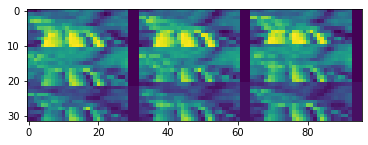

In [21]:
for x, y in train_loader:
  print(x.shape)
  print(y)
  fig = plt.figure()
  plt.imshow(x[0].reshape(x[0].shape[1], -1))
  break

## Metric Logger

In [0]:
accuracy_graph = {'train':[], 'test':[], 'epoch': []}
loss_graph = {'train':[], 'test':[], 'epoch': []}

class accumulator():
    def __init__(self):
        self.cnt = 0
        self.obs = 0
        self.loss = 0

    def add(self, predict, output):

        assert len(predict) == len(output)

        self.cnt += self.count(predict, output).cpu().numpy()
        self.obs += len(predict)
    
    def count(self, predict, output):
        correct = torch.sum(torch.argmax(predict, dim=1) == output)
        
        return correct
        
    def loss_update(self, loss, batch_size):
        self.loss += loss * batch_size

    def running_stat(self):
        if self.obs != 0:
            run_acc = 100 * self.cnt / self.obs
            run_loss = self.loss / self.obs
        else: 
            run_acc = 0
            rum_loss = 0

        return run_acc, run_loss

    def reset(self):
        self.__init__()


## Model Training & Evaluation

- save logs at `log_alexnet.txt`
- save model parameters at `alexnet.pt`

In [23]:
# Template for running epoch
def run_epoch(data_loader, metric_accumulator, train=False):

    if train:
        model.train()
        scheduler = lr_scheduler(optimizer, 
                              len(data_loader), 
                              eta_min=lr_min)
    else:
        model.eval()
    
    for inputs, targets in data_loader:

        # Upload data to GPU
        inputs, targets = inputs.cuda(), targets.cuda()
        if train:
            predict = model(inputs)    
        else:
            with torch.autograd.no_grad():
                predict = model(inputs)

        # Compute loss
        loss = criterion(predict, targets)

        # Backpropagation
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            scheduler.step()

        metric_accumulator.add(predict, targets)
        metric_accumulator.loss_update(loss, batch_size)

# Log initiate
with open("log_alexnet.txt", "w") as log:
    init_log = "Epoch: {}, Batch size: {}, Optimizer: {}".format(num_epochs, 
                                                                 batch_size, 
                                                                 optimizer)
    log.write(init_log)

# Experiment
for epoch in range(num_epochs):

    train_accuracy = accumulator()
    test_accuracy = accumulator()

    # Training
    run_epoch(train_loader, train_accuracy, train=True)

    # Evaluation
    if epoch % 10 ==0:
            
        run_epoch(test_loader, test_accuracy, train=False)

        train_acc, train_loss = train_accuracy.running_stat()
        test_acc, test_loss = test_accuracy.running_stat()
        accuracy_graph['train'].append(train_acc)
        accuracy_graph['test'].append(test_acc) 
        accuracy_graph['epoch'].append(epoch)
        loss_graph['train'].append(train_loss)
        loss_graph['test'].append(test_loss)
        loss_graph['epoch'].append(epoch)
        
        # Upodate log
        log_accuracy = "\ntrain accuracy: {:.2f}%, test accuracy: {:.2f}%".format(train_acc, 
                                                                                  test_acc)
        log_epoch = "\nepoch:{}, train_loss: {:.4f}, test_loss: {:.4f}".format(epoch+1, 
                                                                               train_loss, 
                                                                               test_loss)

        with open("log_alexnet.txt", "a") as log:
            log.write(log_accuracy)
            log.write(log_epoch)
            print(log_accuracy, log_epoch) 

        train_accuracy.reset(), test_accuracy.reset()
        
        # Model save
        torch.save(model.state_dict(), "./alexnet.pt")




train accuracy: 28.72%, test accuracy: 41.10% 
epoch:1, train_loss: 1.8644, test_loss: 1.5536

train accuracy: 66.21%, test accuracy: 70.18% 
epoch:11, train_loss: 0.9563, test_loss: 0.8455

train accuracy: 74.00%, test accuracy: 77.60% 
epoch:21, train_loss: 0.7481, test_loss: 0.6573

train accuracy: 77.95%, test accuracy: 80.15% 
epoch:31, train_loss: 0.6378, test_loss: 0.5840

train accuracy: 80.45%, test accuracy: 82.05% 
epoch:41, train_loss: 0.5731, test_loss: 0.5356

train accuracy: 82.08%, test accuracy: 83.00% 
epoch:51, train_loss: 0.5204, test_loss: 0.5139

train accuracy: 83.59%, test accuracy: 83.78% 
epoch:61, train_loss: 0.4781, test_loss: 0.4879

train accuracy: 84.77%, test accuracy: 84.05% 
epoch:71, train_loss: 0.4441, test_loss: 0.4810

train accuracy: 85.63%, test accuracy: 84.61% 
epoch:81, train_loss: 0.4205, test_loss: 0.4663

train accuracy: 86.00%, test accuracy: 84.87% 
epoch:91, train_loss: 0.4060, test_loss: 0.4630

train accuracy: 86.89%, test accuracy: 8

## Plot Loss Curve and Accuracy

- Need `matplotlib.pyplot` library

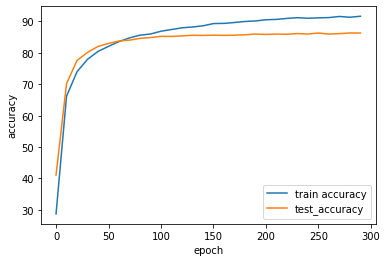

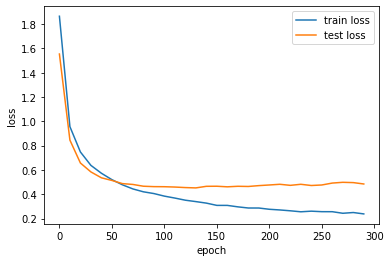

In [24]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.plot(accuracy_graph['epoch'], accuracy_graph['train'], label = "train accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['test'], label = "test_accuracy");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

plot_loss_train = plt.plot(loss_graph['epoch'], loss_graph['train'], label="train loss");
plt.plot(loss_graph['epoch'], loss_graph['test'], label="test loss");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()